# Introduction

This notebook explores two clustering techniques — **K-Means Clustering** and **Prototype-Based Clustering (Fuzzy C-Means)** — applied to the *Sales Transactions Weekly Dataset*. The primary objective is to identify meaningful groups of products based on their normalized weekly sales patterns. By comparing these clustering algorithms, we aim to evaluate their effectiveness and understand their strengths and limitations in discovering underlying structures in the dataset.


## Installing Fuzzy Clustering Library

To implement **Prototype-Based Clustering**, we use the `scikit-fuzzy` library, which provides the functionality for **Fuzzy C-Means (FCM)** clustering. This library is not included in standard Python distributions, so it needs to be installed separately. The installation step is required only once in the environment.


In [48]:
!pip install scikit-fuzzy

## Library Imports

We import the necessary libraries for clustering, preprocessing, visualization, and evaluation:

- **Pandas / NumPy**: Used for efficient data manipulation and numerical operations.
- **Scikit-learn**: Provides tools for clustering (KMeans), data scaling (StandardScaler), dimensionality reduction (PCA), and evaluation metrics.
- **Matplotlib / Seaborn**: Used for generating visualizations to help interpret the clustering results.
- **Warnings**: Suppresses non-critical warning messages for cleaner output.


In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")



## Data Loading and Preprocessing

We begin by loading the *Sales Transactions Weekly Dataset* and selecting only the columns that contain normalized weekly sales data. Although these values are already normalized, we apply `StandardScaler` to ensure consistent feature scaling. Standardization is crucial for distance-based clustering algorithms like K-Means and Fuzzy C-Means, as it prevents features with larger numerical ranges from dominating the clustering process.


In [25]:
# Load the Sales Transactions Dataset
df = pd.read_csv("Sales_Transactions_Dataset_Weekly.csv")

# Extract only the normalized weekly sales columns
normalized_cols = [col for col in df.columns if col.startswith("Normalized")]
df_norm = df[normalized_cols]

# Scale the data (safe even if already normalized)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_norm)


## K-Means Clustering

We apply the **K-Means clustering** algorithm with `k = 3` clusters. K-Means is a hard clustering technique that partitions the dataset into non-overlapping groups based on the minimization of within-cluster variance. Each data point is assigned to the nearest cluster centroid using Euclidean distance. To visualize the clustering outcome in two dimensions, we apply **Principal Component Analysis (PCA)** to reduce the high-dimensional data to two principal components.


In [27]:
# Apply K-Means with k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(df_scaled)


## K-Means Cluster Visualization

To interpret the clustering results visually, we reduce the high-dimensional feature space to two dimensions using **Principal Component Analysis (PCA)**. The resulting 2D projection allows us to plot and examine the cluster assignments made by K-Means. This visualization helps assess how well the clusters are separated in the transformed space.


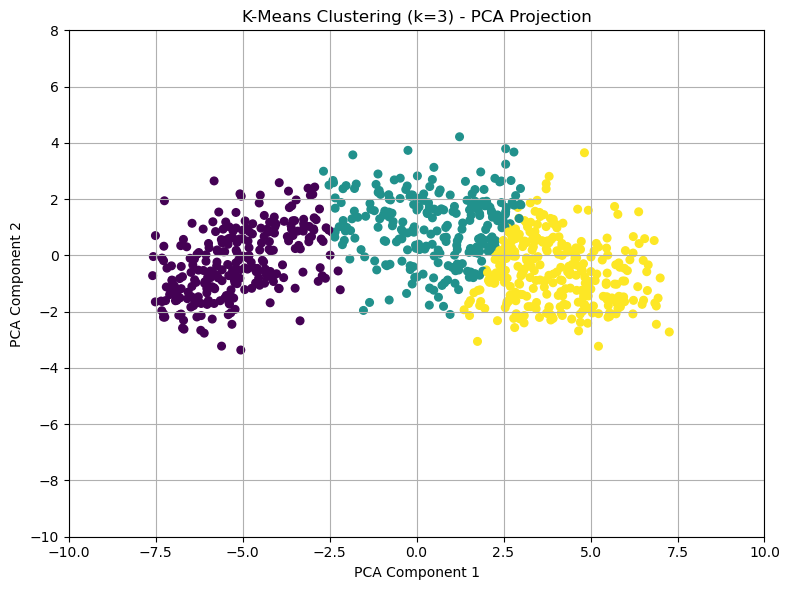

In [9]:
# Visualize using PCA projection (2D)
pca = PCA(n_components=2)
components = pca.fit_transform(df_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1], c=kmeans_labels, cmap='viridis', s=30)
plt.title("K-Means Clustering (k=3) - PCA Projection")
plt.xlim(-10,10)
plt.ylim(-10,8)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


## Storing K-Means Cluster Labels

We construct a new DataFrame that includes the scaled feature data along with the cluster labels assigned by the K-Means algorithm. This structure enables further analysis of the clustering results and facilitates a direct comparison with the labels generated by the Fuzzy C-Means algorithm.


In [11]:
# Store the labels for later comparison
df_kmeans = pd.DataFrame(df_scaled, columns=normalized_cols)
df_kmeans["KMeans_Cluster"] = kmeans_labels


## Prototype-Based Clustering (Fuzzy C-Means)

In contrast to K-Means, which performs hard clustering by assigning each data point to a single cluster, **Fuzzy C-Means (FCM)** employs a soft clustering approach. Each data point is associated with a membership score for every cluster, indicating the degree to which it belongs to each group. This method allows for more flexible and realistic clustering, particularly in scenarios where cluster boundaries are ambiguous or overlapping.


In [13]:
import skfuzzy as fuzz

# Transpose the data to match skfuzzy format (features x samples)
data_fcm = df_scaled.T

# Apply Fuzzy C-Means (c=3 clusters, m=2 is default fuzziness)
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data_fcm, c=3, m=2.0, error=0.005, maxiter=1000, init=None, seed=42
)

# Get final cluster assignment by highest membership degree
fcm_labels = np.argmax(u, axis=0)

# Add FCM cluster labels to DataFrame
df_fcm = pd.DataFrame(df_scaled, columns=normalized_cols)
df_fcm["FCM_Cluster"] = fcm_labels


## Fuzzy C-Means Cluster Visualization

We apply **Principal Component Analysis (PCA)** once again to reduce the dimensionality of the dataset for visualization purposes. The Fuzzy C-Means cluster assignments are determined based on the highest membership value for each data point. This 2D plot provides insights into how the clusters are formed and highlights the potential overlap between clusters due to the soft clustering nature of FCM.


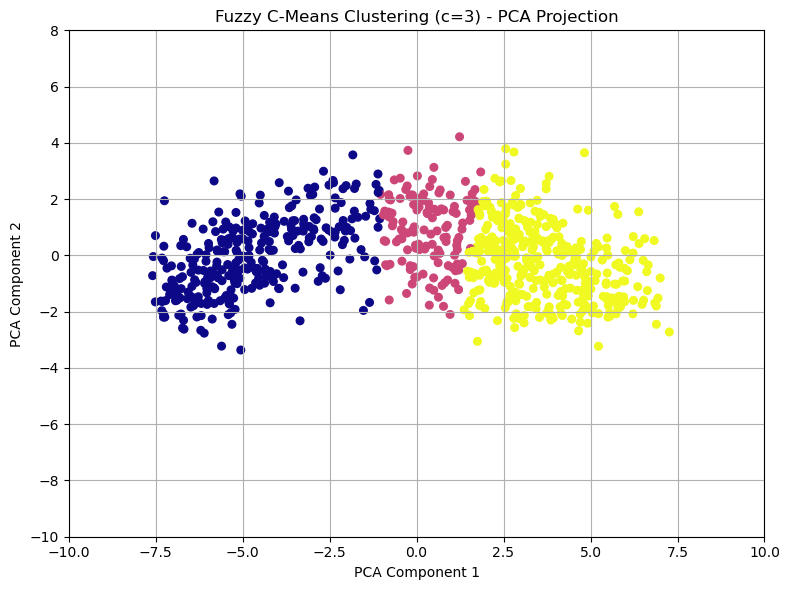

In [15]:
# Visualize FCM clustering results using PCA
plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1], c=fcm_labels, cmap='plasma', s=30)
plt.title("Fuzzy C-Means Clustering (c=3) - PCA Projection")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.xlim(-10,10)
plt.ylim(-10,8)
plt.grid(True)
plt.tight_layout()
plt.show()


## Clustering Evaluation

To assess the performance of the clustering algorithms, we use three standard internal evaluation metrics:

- **Silhouette Score**: Evaluates the cohesion and separation of clusters. Values range from -1 to 1, with higher values indicating better-defined clusters.
- **Davies-Bouldin Index**: Measures the average similarity between each cluster and its most similar one. Lower values indicate better separation and compactness.
- **Calinski-Harabasz Index**: Computes the ratio of between-cluster dispersion to within-cluster dispersion. Higher values suggest well-defined and distinct clusters.

These metrics collectively help evaluate the quality, compactness, and separability of the clustering results.


In [17]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Silhouette Score (higher is better)
sil_kmeans = silhouette_score(df_scaled, df_kmeans["KMeans_Cluster"])
sil_fcm = silhouette_score(df_scaled, df_fcm["FCM_Cluster"])

# Davies-Bouldin Index (lower is better)
db_kmeans = davies_bouldin_score(df_scaled, df_kmeans["KMeans_Cluster"])
db_fcm = davies_bouldin_score(df_scaled, df_fcm["FCM_Cluster"])

# Calinski-Harabasz Index (higher is better)
ch_kmeans = calinski_harabasz_score(df_scaled, df_kmeans["KMeans_Cluster"])
ch_fcm = calinski_harabasz_score(df_scaled, df_fcm["FCM_Cluster"])


In [21]:
# Print metric comparison
print("Clustering Evaluation Comparison")
print("Silhouette Score       → K-Means:", round(sil_kmeans, 4), "| FCM:", round(sil_fcm, 4))
print("Davies-Bouldin Index   → K-Means:", round(db_kmeans, 4), "| FCM:", round(db_fcm, 4))
print("Calinski-Harabasz Index→ K-Means:", round(ch_kmeans, 2),   "| FCM:", round(ch_fcm, 2))


Clustering Evaluation Comparison
Silhouette Score       → K-Means: 0.1022 | FCM: 0.0759
Davies-Bouldin Index   → K-Means: 2.6778 | FCM: 2.9086
Calinski-Harabasz Index→ K-Means: 169.47 | FCM: 161.21


## Conclusion

This analysis highlights the application and comparison of **K-Means** and **Fuzzy C-Means** clustering techniques on weekly sales transaction data. K-Means provides a straightforward and computationally efficient approach with clearly defined cluster boundaries. In contrast, Fuzzy C-Means offers a flexible, soft clustering strategy that accounts for uncertainty and overlapping membership.

While K-Means achieved slightly better evaluation scores in this case, Fuzzy C-Means may be more appropriate in scenarios where data points exhibit mixed characteristics across clusters. Ultimately, the choice of clustering algorithm should be guided by the nature of the dataset and the specific goals of the analysis.